In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('features.py'), '..')))

from NBAData.features import *

### *basic outline:* team/player data -> assign rest days -> assign_postion (encode it) -> assign if starter (encode it) -> opp/team encode it -> prop features -> player prop matchup data

In [45]:
pd.set_option('display.max_columns', None)
s21_playoffs = pd.read_csv('../PLAYOFF_DATA/PLAYOFFS_21_FEATURES.csv')
s21_playoffs['IS_PLAYOFF'] = 1
s21_regular = pd.read_csv('../REGULAR_DATA/SEASON_21_FEATURES.csv')
s21_regular['IS_PLAYOFF'] = 0
s21 = pd.concat([s21_playoffs, s21_regular])

s22_playoffs = pd.read_csv('../PLAYOFF_DATA/PLAYOFFS_22_FEATURES.csv')
s22_playoffs['IS_PLAYOFF'] = 1
s22_regular = pd.read_csv('../REGULAR_DATA/SEASON_22_FEATURES.csv')
s22_regular['IS_PLAYOFF'] = 0
s22 = pd.concat([s22_playoffs, s22_regular])

s23_playoffs = pd.read_csv('../PLAYOFF_DATA/PLAYOFFS_23_FEATURES.csv')
s23_playoffs['IS_PLAYOFF'] = 1
s23_regular = pd.read_csv('../REGULAR_DATA/SEASON_23_FEATURES.csv')
s23_regular['IS_PLAYOFF'] = 0
s23 = pd.concat([s23_playoffs, s23_regular])

s24_playoffs = pd.read_csv('../PLAYOFF_DATA/PLAYOFFS_24_FEATURES.csv')
s24_playoffs['IS_PLAYOFF'] = 1
s24_regular = pd.read_csv('../REGULAR_DATA/SEASON_24_FEATURES.csv')
s24_regular['IS_PLAYOFF'] = 0
s24 = pd.concat([s24_playoffs, s24_regular])

s25_playoffs = pd.read_csv('../PLAYOFF_DATA/PLAYOFFS_25_FEATURES.csv')
s25_playoffs['IS_PLAYOFF'] = 1
s25_regular = pd.read_csv('../REGULAR_DATA/SEASON_25_FEATURES.csv')
s25_regular['IS_PLAYOFF'] = 0
s25 = pd.concat([s25_playoffs, s25_regular])

In [50]:
all_playoff_data = pd.concat([s21, s22, s23, s24, s25])
print(f"Data has {all_playoff_data.shape[0]} rows and {all_playoff_data.shape[1]} columns")
all_playoff_data

Data has 136617 rows and 151 columns


,Unnamed: 0,PLAYER_NAME,PLAYER_ID,MATCHUP,TEAM_ABBREVIATION,TEAM_ID,OPP_ABBREVIATION,HOME_GAME,GAME_ID,GAME_DATE,WL,MIN,PTS,AST,REB,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,STL,BLK,TOV,PF,PLUS_MINUS,FANTASY_PTS,PointsPerShot,eFG,START_POSITION,COMMENT,OFF_RATING,E_OFF_RATING,DEF_RATING,E_DEF_RATING,NET_RATING,OREB_PCT,DREB_PCT,REB_PCT,AST_PCT,EFG_PCT,AST_TOV,USG_PCT,TS_PCT,E_PACE,PACE,PIE,POSS,PACE_PER40,E_USG_PCT,TEAM_GAME_DATE,TEAM_MIN,TEAM_FGM,TEAM_FGA,TEAM_FG_PCT,TEAM_FG3M,TEAM_FG3A,TEAM_FG3_PCT,TEAM_FTM,TEAM_FTA,TEAM_FT_PCT,TEAM_OREB,TEAM_DREB,TEAM_REB,TEAM_AST,TEAM_STL,TEAM_BLK,TEAM_TOV,TEAM_PF,TEAM_PTS,OPP_DEF_RATING,OPP_STL,OPP_BLK,OPP_REB,OPP_FG_PCT,OPP_TEAM_ID,TEAM_OFF_RATING,TEAM_PACE,GAME_PACE,OPP_PACE,STARTING,PTS_ROLL_AVG_2,PTS_STD_AVG_2,MIN_ROLL_AVG_2,FG_PCT_ROLL_AVG_2,FGM_ROLL_AVG_2,FGA_ROLL_AVG_2,FG3M_ROLL_AVG_2,FG3A_ROLL_AVG_2,FG3_PCT_ROLL_AVG_2,FTM_ROLL_AVG_2,FT_PCT_ROLL_AVG_2,REB_ROLL_AVG_2,AST_ROLL_AVG_2,USG_PCT_ROLL_AVG_2,PTS_ROLL_AVG_4,PTS_STD_AVG_4,MIN_ROLL_AVG_4,FG_PCT_ROLL_AVG_4,FGM_ROLL_AVG_4,FGA_ROLL_AVG_4,FG3M_ROLL_AVG_4,FG3A_ROLL_AVG_4,FG3_PCT_ROLL_AVG_4,FTM_ROLL_AVG_4,FT_PCT_ROLL_AVG_4,REB_ROLL_AVG_4,AST_ROLL_AVG_4,USG_PCT_ROLL_AVG_4,PTS_ROLL_AVG_6,PTS_STD_AVG_6,MIN_ROLL_AVG_6,FG_PCT_ROLL_AVG_6,FGM_ROLL_AVG_6,FGA_ROLL_AVG_6,FG3M_ROLL_AVG_6,FG3A_ROLL_AVG_6,FG3_PCT_ROLL_AVG_6,FTM_ROLL_AVG_6,FT_PCT_ROLL_AVG_6,REB_ROLL_AVG_6,AST_ROLL_AVG_6,USG_PCT_ROLL_AVG_6,PLAYER_HOME_AVG_PTS,PLAYER_AWAY_AVG_PTS,DAYS_OF_REST,DAYS_AGO,PTS_LAG_1,PTS_LAG_2,PTS_LAG_3,PTS_LAG_4,OPP_ROLL_OPP_DEF_RATING_5,OPP_ROLL_OPP_STL_5,OPP_ROLL_OPP_BLK_5,NORMALIZED_DEF_RATING,OPP_DEF_STRENGTH,DEF_CATEGORY,PTS_VS_DEF,FGA_VS_DEF,FTA_VS_DEF,FG3A_VS_DEF,USG_PCT_VS_DEF,GUARD,FORWARD,CENTER,IS_PLAYOFF
0,18,James Harden,201935,BKN vs. BOS,BKN,1610612751,BOS,1,42000111,2021-05-22,W,36,21,8,9,5,13,0.385,2,8,0.250,9,10,0.900,0,9,4,1,3,2,2,55.8,1.207,0.461538,G,NaN,104.2,106.7,104.3,98.9,-0.1,0.000,0.220,0.120,0.381,0.462,2.67,0.263,0.603,94.14,92.71,0.235,71.0,77.26,0.275,"MAY 22, 2021",240,35,84,0.417,8,34,0.235,26,29,0.897,14,36,50,18,7,7,11,22,104,110.921502,6.0,12.0,40.0,0.369048,1.610613e+09,110.921502,93.76,95.10,96.44,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.00,NaN,NaN,1487,NaN,NaN,NaN,NaN,110.92,6.0,12.0,0.109626,1.239541,1,0.063,0.020,0.379,-0.059,0.143,1,0,0,1
1,54,JaMychal Green,203210,DEN vs. POR,DEN,1610612743,POR,1,42000161,2021-05-22,L,18,0,3,1,0,1,0.000,0,1,0.000,0,0,NaN,0,1,0,1,0,2,-6,8.7,0.000,0.000000,NaN,NaN,127.3,127.3,145.5,142.7,-18.2,0.000,0.071,0.038,0.158,0.000,0.00,0.028,0.000,90.79,89.91,0.018,33.0,74.93,0.029,"MAY 22, 2021",240,47,93,0.505,11,36,0.306,4,8,0.500,11,37,48,22,3,7,8,18,109,116.552609,3.0,2.0,39.0,0.472527,1.610613e+09,116.552609,93.52,94.44,95.36,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,1487,NaN,NaN,NaN,NaN,116.55,3.0,2.0,-0.348293,0.183784,0,-1.000,-0.762,-1.000,-0.444,-0.720,0,1,1,1
2,43,Marcus Morris Sr.,202694,LAC vs. DAL,LAC,1610612746,DAL,1,42000171,2021-05-22,L,33,4,1,2,2,8,0.250,0,6,0.000,0,2,0.000,1,1,0,2,0,2,-23,13.9,0.450,0.250000,F,NaN,95.1,95.5,135.0,130.8,-39.9,0.025,0.042,0.031,0.050,0.250,0.00,0.125,0.225,90.19,88.98,-0.022,61.0,74.15,0.127,"MAY 22, 2021",240,37,84,0.440,11,40,0.275,18,24,0.750,13,26,39,22,7,7,5,21,103,118.992606,2.0,3.0,42.0,0.500000,1.610613e+09,118.992606,86.56,88.00,89.44,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.00,NaN,NaN,1487,NaN,NaN,NaN,NaN,118.99,2.0,3.0,-0.546752,0.143344,0,-0.684,-0.194,0.075,0.235,-0.265,0,1,0,1
3,19,Rajon Rondo,200765,LAC vs. DAL,LAC,1610612746,DAL,1,42000171,2021-05-22,L,24,11,4,4,3,6,0.500,3,4,0.750,2,4,0.500,0,4,1,1,1,2,-8,2

### Features that will be used to train my XGBoost model

In [51]:
features = [
    'MIN','FGA', 'FTA', 'FG3A','FG_PCT', 'FT_PCT', 'FG3_PCT', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
    'OFF_RATING','E_OFF_RATING', 'DEF_RATING', 'E_DEF_RATING', 'NET_RATING', 'PointsPerShot', 'eFG',
    'AST_PCT', 'AST_TOV','USG_PCT', 'TS_PCT','PACE', 'PIE', 'POSS', 'E_USG_PCT',
    'TEAM_FGA', 'TEAM_FG3A','TEAM_FTA','TEAM_AST', 'TEAM_REB', 'TEAM_STL', 'TEAM_BLK', 
    'TEAM_TOV', 'TEAM_PF','TEAM_OFF_RATING', 'TEAM_PACE', 'PTS_VS_DEF',
    'FGA_VS_DEF', 'FTA_VS_DEF', 'FG3A_VS_DEF', 'USG_PCT_VS_DEF',
    #grab oppenents avgerages for the game
    'OPP_PACE', 'OPP_DEF_RATING','OPP_STL', 'OPP_BLK', 'OPP_REB', 'OPP_FG_PCT',
    #rolling averages
    'PTS_ROLL_AVG_2', 'PTS_STD_AVG_2', 'MIN_ROLL_AVG_2', 'FG_PCT_ROLL_AVG_2', 'FGM_ROLL_AVG_2', 'FGA_ROLL_AVG_2', 'FG3M_ROLL_AVG_2', 'FG3A_ROLL_AVG_2', 'FG3_PCT_ROLL_AVG_2', 'FTM_ROLL_AVG_2', 'FT_PCT_ROLL_AVG_2', 'REB_ROLL_AVG_2', 'AST_ROLL_AVG_2', 'USG_PCT_ROLL_AVG_2', 
    'PTS_ROLL_AVG_4', 'PTS_STD_AVG_4', 'MIN_ROLL_AVG_4', 'FG_PCT_ROLL_AVG_4', 'FGM_ROLL_AVG_4', 'FGA_ROLL_AVG_4', 'FG3M_ROLL_AVG_4', 'FG3A_ROLL_AVG_4', 'FG3_PCT_ROLL_AVG_4', 'FTM_ROLL_AVG_4', 'FT_PCT_ROLL_AVG_4', 'REB_ROLL_AVG_4', 'AST_ROLL_AVG_4', 'USG_PCT_ROLL_AVG_4',
    'PTS_ROLL_AVG_6', 'PTS_STD_AVG_6', 'MIN_ROLL_AVG_6', 'FG_PCT_ROLL_AVG_6', 'FGM_ROLL_AVG_6', 'FGA_ROLL_AVG_6', 'FG3M_ROLL_AVG_6', 'FG3A_ROLL_AVG_6', 'FG3_PCT_ROLL_AVG_6', 'FTM_ROLL_AVG_6', 'FT_PCT_ROLL_AVG_6', 'REB_ROLL_AVG_6', 'AST_ROLL_AVG_6', 'USG_PCT_ROLL_AVG_6',
    'PTS_LAG_1', 'PTS_LAG_2', 'PTS_LAG_3', 'PTS_LAG_4','PLAYER_HOME_AVG_PTS', 'PLAYER_AWAY_AVG_PTS',
    #ill input these during prediction
    'GUARD', 'FORWARD', 'CENTER', 'STARTING', 'DAYS_OF_REST', 'HOME_GAME', 'IS_PLAYOFF'
]

In [48]:
corr_matrix = all_playoff_data.corr(numeric_only=True)
target = corr_matrix['PTS'].sort_values(ascending=False).head(15)
target


PTS                    1.000000
FGM                    0.968436
FGA                    0.894092
FANTASY_PTS            0.888251
PLAYER_HOME_AVG_PTS    0.792540
PLAYER_AWAY_AVG_PTS    0.788783
POSS                   0.743065
MIN                    0.740519
FGA_ROLL_AVG_6         0.717840
PTS_ROLL_AVG_6         0.716196
FGA_ROLL_AVG_4         0.711379
PTS_ROLL_AVG_4         0.704629
FGM_ROLL_AVG_6         0.703895
FGM_ROLL_AVG_4         0.690520
FGA_ROLL_AVG_2         0.689617
Name: PTS, dtype: float64

## Train XGBoost model

In [52]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

X = all_playoff_data[features]
y = all_playoff_data['PTS']

all_playoff_data.sort_values(by='GAME_DATE', ascending=False, inplace=True)
weights = np.linspace(1,3,num=len(all_playoff_data))**2

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X, y, weights, test_size=0.2, random_state=42)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
# XGBoost model
XGB_model = xgb.XGBRegressor(
    random_state=42
)
grid_search = GridSearchCV(
    estimator=XGB_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train, sample_weight=weights_train)
print("Best Parameters:", grid_search.best_params_)

# Evaluate on test set
best_model = grid_search.best_estimator_
pred = best_model.predict(X_test)

# XGB_model.fit(X_train, y_train, sample_weight=weights_train)
# pred = XGB_model.predict(X_test)

print(f"R-squared: {round(r2_score(y_test, pred), 3)}")
print(f"Mean Absolute Error: {round(mean_absolute_error(y_test, pred), 3)}")
print(f"Mean Squared Error: {round(mean_squared_error(y_test, pred), 3)}")



Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.6}
R-squared: 1.0
Mean Absolute Error: 0.062
Mean Squared Error: 0.018


In [53]:
import joblib

joblib.dump(XGB_model, 'XGB_PTS_MODEL.pkl')

# best_model = joblib.load('XGB_PTS_MODEL.pkl') #loads the model

['XGB_PTS_MODEL.pkl']

### How the model performed with existing data

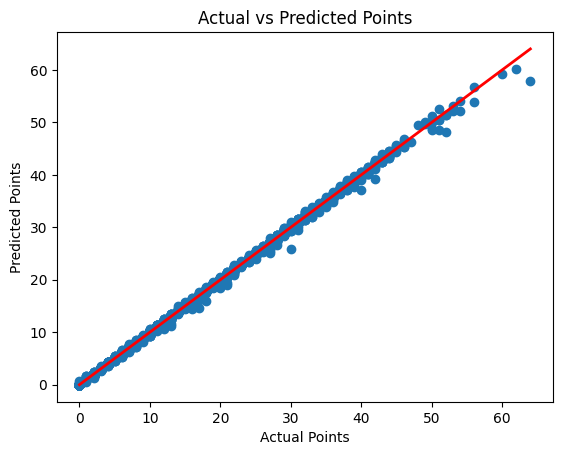

In [54]:
plt.scatter(y_test, pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')
plt.title('Actual vs Predicted Points')
plt.show()

### Check to see which features to keep and remove

In [ ]:
import shap

# Create SHAP explainer
explainer = shap.TreeExplainer(XGB_model)
shap_values = explainer.shap_values(X)

# Get feature importance scores
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': np.abs(shap_values).mean(axis=0)
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(feature_importance.head(15))

## Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestRegressor

X = all_playoff_data[features]
y = all_playoff_data['PTS']

all_playoff_data.sort_values(by='GAME_DATE', ascending=False, inplace=True)
rf_weights = np.linspace(1,2,num=len(all_playoff_data))

X_train, X_test, y_train, y_test, rf_weights_train, rf_weights_test = train_test_split(X, y, rf_weights, test_size=0.2, random_state=42)

# XGBoost model
rf_model = RandomForestRegressor(n_estimators=150)
rf_model.fit(X_train, y_train, sample_weight=rf_weights_train)
pred = rf_model.predict(X_test)

print(f"R-squared: {round(r2_score(y_test, pred), 3)}")
print(f"Mean Absolute Error: {round(mean_absolute_error(y_test, pred), 3)}")
print(f"Mean Squared Error: {round(mean_squared_error(y_test, pred), 3)}")

### Same features, but this includes name, opp, and game_date for my functions

In [55]:
avg_features = [
    'PLAYER_NAME','TEAM_ABBREVIATION','OPP_ABBREVIATION', 'GAME_DATE',
    'MIN','FGA', 'FTA', 'FG3A','FG_PCT', 'FT_PCT', 'FG3_PCT', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
    'OFF_RATING','E_OFF_RATING', 'DEF_RATING', 'E_DEF_RATING', 'NET_RATING', 'PointsPerShot', 'eFG',
    'AST_PCT', 'AST_TOV','USG_PCT', 'TS_PCT','PACE', 'PIE', 'POSS', 'E_USG_PCT',
    'TEAM_FGA', 'TEAM_FG3A','TEAM_FTA','TEAM_AST', 'TEAM_REB', 'TEAM_STL', 'TEAM_BLK', 
    'TEAM_TOV', 'TEAM_PF','TEAM_OFF_RATING', 'TEAM_PACE', 'PTS_VS_DEF',
    'FGA_VS_DEF', 'FTA_VS_DEF', 'FG3A_VS_DEF', 'USG_PCT_VS_DEF',
    #grab oppenents avgerages for the game
    'OPP_PACE', 'OPP_DEF_RATING','OPP_STL', 'OPP_BLK', 'OPP_REB', 'OPP_FG_PCT',
    #rolling averages
    'PTS_ROLL_AVG_2', 'PTS_STD_AVG_2', 'MIN_ROLL_AVG_2', 'FG_PCT_ROLL_AVG_2', 'FGM_ROLL_AVG_2', 'FGA_ROLL_AVG_2', 'FG3M_ROLL_AVG_2', 'FG3A_ROLL_AVG_2', 'FG3_PCT_ROLL_AVG_2', 'FTM_ROLL_AVG_2', 'FT_PCT_ROLL_AVG_2', 'REB_ROLL_AVG_2', 'AST_ROLL_AVG_2', 'USG_PCT_ROLL_AVG_2', 
    'PTS_ROLL_AVG_4', 'PTS_STD_AVG_4', 'MIN_ROLL_AVG_4', 'FG_PCT_ROLL_AVG_4', 'FGM_ROLL_AVG_4', 'FGA_ROLL_AVG_4', 'FG3M_ROLL_AVG_4', 'FG3A_ROLL_AVG_4', 'FG3_PCT_ROLL_AVG_4', 'FTM_ROLL_AVG_4', 'FT_PCT_ROLL_AVG_4', 'REB_ROLL_AVG_4', 'AST_ROLL_AVG_4', 'USG_PCT_ROLL_AVG_4',
    'PTS_ROLL_AVG_6', 'PTS_STD_AVG_6', 'MIN_ROLL_AVG_6', 'FG_PCT_ROLL_AVG_6', 'FGM_ROLL_AVG_6', 'FGA_ROLL_AVG_6', 'FG3M_ROLL_AVG_6', 'FG3A_ROLL_AVG_6', 'FG3_PCT_ROLL_AVG_6', 'FTM_ROLL_AVG_6', 'FT_PCT_ROLL_AVG_6', 'REB_ROLL_AVG_6', 'AST_ROLL_AVG_6', 'USG_PCT_ROLL_AVG_6',
    'PTS_LAG_1', 'PTS_LAG_2', 'PTS_LAG_3', 'PTS_LAG_4','PLAYER_HOME_AVG_PTS', 'PLAYER_AWAY_AVG_PTS',
    #ill input these during prediction
    'GUARD', 'FORWARD', 'CENTER', 'STARTING', 'DAYS_OF_REST', 'HOME_GAME', 'IS_PLAYOFF'
]

In [57]:
import requests # type: ignore
from datetime import datetime
import pytz # type: ignore

today = datetime.today().strftime('%Y-%m-%d')

def get_espn_games(date_str='20250616'):  # YYYYMMDD format
    url = f"http://site.api.espn.com/apis/site/v2/sports/basketball/nba/scoreboard?dates={date_str}"
    response = requests.get(url)
    data = response.json()
    
    # Define timezone objects
    utc = pytz.UTC
    pst = pytz.timezone('America/Los_Angeles')

    games_list = []
    for event in data['events']:
        # Parse UTC time from ESPN
        utc_time = datetime.strptime(event['date'], '%Y-%m-%dT%H:%MZ').replace(tzinfo=utc)
        # Convert to PST
        pst_time = utc_time.astimezone(pst)
        
        game_dict = {
            'game_date': pst_time.strftime('%Y-%m-%d'),
            'home_team': event['competitions'][0]['competitors'][0]['team']['abbreviation'],
            'away_team': event['competitions'][0]['competitors'][1]['team']['abbreviation'],
            'game_time': pst_time.strftime('%I:%M %p'),  # 12-hour format with AM/PM
            'venue': event['competitions'][0]['venue']['fullName']
        }
        games_list.append(game_dict)
    
    return games_list

def getPlayerAVG(player, data):
    player_data = data[data['PLAYER_NAME'] == player]
    exclude = ['PLAYER_NAME','TEAM_ABBREVIATION','OPP_ABBREVIATION', 'GAME_DATE', 'OPP_PACE', 'OPP_DEF_RATING','OPP_STL', 'OPP_BLK', 'OPP_REB', 'OPP_FG_PCT',
    'PTS_ROLL_AVG_2', 'PTS_STD_AVG_2', 'MIN_ROLL_AVG_2', 'FG_PCT_ROLL_AVG_2', 'FGM_ROLL_AVG_2', 'FGA_ROLL_AVG_2', 'FG3M_ROLL_AVG_2', 'FG3A_ROLL_AVG_2', 'FG3_PCT_ROLL_AVG_2', 'FTM_ROLL_AVG_2', 'FT_PCT_ROLL_AVG_2', 'REB_ROLL_AVG_2', 'AST_ROLL_AVG_2', 'USG_PCT_ROLL_AVG_2', 
    'PTS_ROLL_AVG_4', 'PTS_STD_AVG_4', 'MIN_ROLL_AVG_4', 'FG_PCT_ROLL_AVG_4', 'FGM_ROLL_AVG_4', 'FGA_ROLL_AVG_4', 'FG3M_ROLL_AVG_4', 'FG3A_ROLL_AVG_4', 'FG3_PCT_ROLL_AVG_4', 'FTM_ROLL_AVG_4', 'FT_PCT_ROLL_AVG_4', 'REB_ROLL_AVG_4', 'AST_ROLL_AVG_4', 'USG_PCT_ROLL_AVG_4',
    'PTS_ROLL_AVG_6', 'PTS_STD_AVG_6', 'MIN_ROLL_AVG_6', 'FG_PCT_ROLL_AVG_6', 'FGM_ROLL_AVG_6', 'FGA_ROLL_AVG_6', 'FG3M_ROLL_AVG_6', 'FG3A_ROLL_AVG_6', 'FG3_PCT_ROLL_AVG_6', 'FTM_ROLL_AVG_6', 'FT_PCT_ROLL_AVG_6', 'REB_ROLL_AVG_6', 'AST_ROLL_AVG_6', 'USG_PCT_ROLL_AVG_6',
    'PTS_LAG_1', 'PTS_LAG_2', 'PTS_LAG_3', 'PTS_LAG_4','PLAYER_HOME_AVG_PTS', 'PLAYER_AWAY_AVG_PTS', 'GUARD', 'FORWARD', 'CENTER', 'STARTING', 'DAYS_OF_REST', 'HOME_GAME', 'IS_PLAYOFF'
]
    res = [round(player_data[col].mean(), 2) for col in avg_features if col not in exclude]
    return res

def getOppAVG(team, data):
    team_data = data[data['OPP_ABBREVIATION'] == team]
    
    include = ['OPP_DEF_RATING', 'OPP_STL',	'OPP_BLK','OPP_REB','OPP_FG_PCT','OPP_PACE']
    
    team_stats = team_data.groupby('GAME_DATE')[include].mean().reset_index()
    return [round(team_stats[col].mean(), 2) for col in include]

def getPlayerRollingAVG(player, data):
    player = data[data['PLAYER_NAME'] == player].copy()
    player.sort_values(by='GAME_DATE', inplace=True)
    res = []
    include = ['PTS_ROLL_AVG_2', 'PTS_STD_AVG_2', 'MIN_ROLL_AVG_2', 'FG_PCT_ROLL_AVG_2', 'FGM_ROLL_AVG_2', 'FGA_ROLL_AVG_2', 'FG3M_ROLL_AVG_2', 'FG3A_ROLL_AVG_2', 'FG3_PCT_ROLL_AVG_2', 'FTM_ROLL_AVG_2', 'FT_PCT_ROLL_AVG_2', 'REB_ROLL_AVG_2', 'AST_ROLL_AVG_2', 'USG_PCT_ROLL_AVG_2', 
    'PTS_ROLL_AVG_4', 'PTS_STD_AVG_4', 'MIN_ROLL_AVG_4', 'FG_PCT_ROLL_AVG_4', 'FGM_ROLL_AVG_4', 'FGA_ROLL_AVG_4', 'FG3M_ROLL_AVG_4', 'FG3A_ROLL_AVG_4', 'FG3_PCT_ROLL_AVG_4', 'FTM_ROLL_AVG_4', 'FT_PCT_ROLL_AVG_4', 'REB_ROLL_AVG_4', 'AST_ROLL_AVG_4', 'USG_PCT_ROLL_AVG_4',
    'PTS_ROLL_AVG_6', 'PTS_STD_AVG_6', 'MIN_ROLL_AVG_6', 'FG_PCT_ROLL_AVG_6', 'FGM_ROLL_AVG_6', 'FGA_ROLL_AVG_6', 'FG3M_ROLL_AVG_6', 'FG3A_ROLL_AVG_6', 'FG3_PCT_ROLL_AVG_6', 'FTM_ROLL_AVG_6', 'FT_PCT_ROLL_AVG_6', 'REB_ROLL_AVG_6', 'AST_ROLL_AVG_6', 'USG_PCT_ROLL_AVG_6',
    'PTS_LAG_1', 'PTS_LAG_2', 'PTS_LAG_3', 'PTS_LAG_4','PLAYER_HOME_AVG_PTS', 'PLAYER_AWAY_AVG_PTS',]
    for col in include:
        value = player[col].dropna().iloc[-1] if not player[col].dropna().empty else 0
        res.append(value)
    return res

def otherFeatures(player, data, rest_days, games, is_playoff=0):
    player = data[data['PLAYER_NAME'] == player].copy()
    player.sort_values(by='GAME_DATE', inplace=True)
    
    res = []
    res.append(player['GUARD'].iloc[-1])
    res.append(player['FORWARD'].iloc[-1])
    res.append(player['CENTER'].iloc[-1])
    res.append(player['STARTING'].iloc[-1])
    res.append(rest_days)
    for game in games:
        if game['home_team'] == player['TEAM_ABBREVIATION'].iloc[-1]:
            res.append(1)
        else:
            res.append(0)
    res.append(is_playoff)
    return res

def buildFeatureVector(player, opponent, rest_days, data, df, games, is_playoff):
    features = (getPlayerAVG(player, df) + 
                   getOppAVG(opponent, data) + 
                   getPlayerRollingAVG(player, df) + 
                   otherFeatures(player, df, rest_days, games, is_playoff))
    return features

def make_points_prediction(player_name, opponent, rest_days, model, data, df, games, is_playoff):
    try:
        features = buildFeatureVector(player_name, opponent, rest_days, data, df, games, is_playoff)
        X_pred = pd.DataFrame([features], columns=model.feature_names_in_)
        prediction = model.predict(X_pred)[0]
        return {
            'player': player_name,
            'opponent': opponent,
            'predicted_points': round(prediction),
        }
    except Exception as e:
        print(f"Error making prediction for {player_name}: {str(e)}")
        return None

def analyze_points_prop(prediction, prop_line):
    if not prediction:
        return None
    
    edge = round(float(prediction['predicted_points']) - prop_line, 1)
    
    res = {
        'player': prediction['player'],
        'opponent': prediction['opponent'],
        'predicted_points': prediction['predicted_points'],
        'prop_line': prop_line,
        'edge': edge,
        'recommendation': 'OVER' if edge > 0 else 'UNDER'
    }
    return pd.DataFrame([res])
    

### Use the xgboost model to predict there points and compare the there line

In [58]:
propsData = pd.read_csv('../PROPS_DATA/Playoffs_DFS(06_17_25).csv')
pp = propsData[(propsData['BOOKMAKER'] == 'PrizePicks') & (propsData['CATEGORY'] == 'player_points')]
pp = pp[['NAME', 'LINE']].drop_duplicates()

games_today = get_espn_games()

In [59]:
from tqdm import tqdm  # Optional: for a progress bar

results = []

for name in tqdm(pp['NAME'].unique(), desc="Processing players"):
    try:
        # Filter player history
        player_df = s25[s25['PLAYER_NAME'] == name].sort_values(by='GAME_DATE')
        if player_df.empty:
            continue
        
        # Rest days
        last_game_date = pd.to_datetime(player_df['GAME_DATE'].iloc[-1])
        rest_days = (datetime.today() - last_game_date).days
        
        # Team info
        player_team = player_df['TEAM_ABBREVIATION'].iloc[-1]

        # Match opponent from today's games
        opponent = None
        for game in games_today:
            if game['home_team'] == player_team:
                opponent = game['away_team']
                break
            elif game['away_team'] == player_team:
                opponent = game['home_team']
                break
        if not opponent:
            continue  # Skip if no game match found

        # Line from prop dataset
        player_line = pp.loc[pp['NAME'] == name, 'LINE'].values[0]

        # Make prediction
        xgb_prediction = make_points_prediction(
            player_name=name,
            opponent=opponent,
            rest_days=rest_days,
            model=best_model,
            data=s25,
            df=s25,
            games=games_today,
            is_playoff=1
        )
        
        xgb_result_df = analyze_points_prop(xgb_prediction, player_line)
        if xgb_result_df is not None:
            results.append(xgb_result_df)
    except Exception as e:
        print(f"Error processing {name}: {e}")
        continue

# Combine all results
if results:
    xgb_final_results_df = pd.concat(results, ignore_index=True)
    display(xgb_final_results_df)
else:
    print("No results generated.")


Processing players: 100%|██████████| 16/16 [00:00<00:00, 21.22it/s]


,player,opponent,predicted_points,prop_line,edge,recommendation
0,Myles Turner,OKC,14,13.5,0.5,OVER
1,T.J. McConnell,OKC,8,10.5,-2.5,UNDER
2,Luguentz Dort,IND,9,8.0,1.0,OVER
3,Aaron Wiggins,IND,9,6.0,3.0,OVER
4,Jalen Williams,IND,22,23.5,-1.5,UNDER
5,Andrew Nembhard,OKC,10,10.5,-0.5,UNDER
6,Aaron Nesmith,OKC,11,11.0,0.0,UNDER
7,Bennedict Mathurin,OKC,14,10.5,3.5,OVER
8,Chet Holmgren,IND,15,15.5,-0.5,UNDER
9,Obi Toppin,OKC,9,10.5,-1.5,UNDER


## Use random forest model to predict players points and compare to there line

In [25]:
from tqdm import tqdm  #for a progress bar

results = []

for name in tqdm(pp['NAME'].unique(), desc="Processing players"):
    try:
        # Filter player history
        player_df = s25[s25['PLAYER_NAME'] == name].sort_values(by='GAME_DATE')
        if player_df.empty:
            continue
        
        # Rest days
        last_game_date = pd.to_datetime(player_df['GAME_DATE'].iloc[-1])
        rest_days = (datetime.today() - last_game_date).days
        
        # Team info
        player_team = player_df['TEAM_ABBREVIATION'].iloc[-1]

        # Match opponent from today's games
        opponent = None
        for game in games_today:
            if game['home_team'] == player_team:
                opponent = game['away_team']
                break
            elif game['away_team'] == player_team:
                opponent = game['home_team']
                break
        if not opponent:
            continue  # Skip if no game match found

        # Line from prop dataset
        player_line = pp.loc[pp['NAME'] == name, 'LINE'].values[0]

        # Make prediction
        rf_prediction = make_points_prediction(
            player_name=name,
            opponent=opponent,
            rest_days=rest_days,
            model=rf_model,
            data=s25,
            df=s25,
            games=games_today
        )
        
        rf_result_df = analyze_points_prop(rf_prediction, player_line)
        if rf_result_df is not None:
            results.append(rf_result_df)
    except Exception as e:
        print(f"Error processing {name}: {e}")
        continue

# Combine all results
if results:
    rf_final_results_df = pd.concat(results, ignore_index=True)
    display(rf_final_results_df)
else:
    print("No results generated.")


Processing players: 100%|██████████| 19/19 [00:00<00:00, 66.38it/s]


,player,opponent,predicted_points,prop_line,edge,recommendation
0,Myles Turner,OKC,15,13.5,1.5,OVER
1,T.J. McConnell,OKC,8,7.5,0.5,OVER
2,Luguentz Dort,IND,8,8.5,-0.5,UNDER
3,Kenrich Williams,IND,3,2.5,0.5,OVER
4,Aaron Wiggins,IND,5,4.5,0.5,OVER
5,Jalen Williams,IND,21,22.5,-1.5,UNDER
6,Andrew Nembhard,OKC,13,10.5,2.5,OVER
7,Aaron Nesmith,OKC,13,11.0,2.0,OVER
8,Bennedict Mathurin,OKC,9,8.5,0.5,OVER
9,Isaiah Joe,IND,4,2.5,1.5,OVER


## Backtest w/ the game prior to see how your model performed
### XGBoost Results

In [33]:
actual_date = '2025-06-16'
completed_games = s25[s25['GAME_DATE'] == actual_date]

xgb_final_results_df['date'] = actual_date 

actual_stats = completed_games[['PLAYER_NAME', 'PTS']].rename(columns={'PLAYER_NAME': 'player', 'PTS': 'actual_points'})

# Merge
results_with_actuals = xgb_final_results_df.merge(actual_stats, on='player', how='left')

results_with_actuals['prediction_error'] = results_with_actuals['predicted_points'] - results_with_actuals['actual_points']
results_with_actuals['was_correct'] = (
    (results_with_actuals['recommendation'] == 'OVER') & (results_with_actuals['actual_points'] > results_with_actuals['prop_line']) |
    (results_with_actuals['recommendation'] == 'UNDER') & (results_with_actuals['actual_points'] < results_with_actuals['prop_line'])
)
display(results_with_actuals[['player', 'predicted_points', 'actual_points', 'prop_line', 'edge', 'recommendation', 'was_correct']])
print(f"Your model was correct {results_with_actuals['was_correct'].sum()} times out of {len(results_with_actuals)}")


,player,predicted_points,actual_points,prop_line,edge,recommendation,was_correct
0,Myles Turner,14,13,13.5,0.5,OVER,False
1,T.J. McConnell,9,18,10.5,-1.5,UNDER,False
2,Luguentz Dort,9,9,8.0,1.0,OVER,True
3,Aaron Wiggins,5,14,6.0,-1.0,UNDER,False
4,Jalen Williams,21,40,23.5,-2.5,UNDER,False
5,Andrew Nembhard,11,7,10.5,0.5,OVER,False
6,Aaron Nesmith,13,14,11.0,2.0,OVER,True
7,Bennedict Mathurin,9,7,10.5,-1.5,UNDER,True
8,Chet Holmgren,15,9,15.5,-0.5,UNDER,True
9,Obi Toppin,10,12,10.5,-0.5,UNDER,False


Your model was correct 7 times out of 16


### Random Forest Results

In [28]:
actual_date = '2025-06-13'
completed_games = s25[s25['GAME_DATE'] == actual_date]

rf_final_results_df['date'] = actual_date 

actual_stats = completed_games[['PLAYER_NAME', 'PTS']].rename(columns={'PLAYER_NAME': 'player', 'PTS': 'actual_points'})

# Merge
results_with_actuals = rf_final_results_df.merge(actual_stats, on='player', how='left')

results_with_actuals['prediction_error'] = results_with_actuals['predicted_points'] - results_with_actuals['actual_points']
results_with_actuals['was_correct'] = (
    (results_with_actuals['recommendation'] == 'OVER') & (results_with_actuals['actual_points'] > results_with_actuals['prop_line']) |
    (results_with_actuals['recommendation'] == 'UNDER') & (results_with_actuals['actual_points'] < results_with_actuals['prop_line'])
)
display(results_with_actuals[['player', 'predicted_points', 'actual_points', 'prop_line', 'edge', 'recommendation', 'was_correct']])
print(f"Your model was correct {results_with_actuals['was_correct'].sum()} times out of {len(results_with_actuals)}")


,player,predicted_points,actual_points,prop_line,edge,recommendation,was_correct
0,Myles Turner,15,12,13.5,1.5,OVER,False
1,T.J. McConnell,8,8,7.5,0.5,OVER,True
2,Luguentz Dort,8,6,8.5,-0.5,UNDER,True
3,Kenrich Williams,3,4,2.5,0.5,OVER,True
4,Aaron Wiggins,5,1,4.5,0.5,OVER,False
5,Jalen Williams,21,27,22.5,-1.5,UNDER,False
6,Andrew Nembhard,13,10,10.5,2.5,OVER,False
7,Aaron Nesmith,13,8,11.0,2.0,OVER,False
8,Bennedict Mathurin,9,8,8.5,0.5,OVER,False
9,Isaiah Joe,4,0,2.5,1.5,OVER,False


Your model was correct 7 times out of 19


In [21]:
xgb_prediction = make_points_prediction(
            player_name='Shai Gilgeous-Alexander',
            opponent='IND',
            rest_days=3,
            model=XGB_model,
            data=s25,
            df=s25,
            games=games_today
        )
xgb_prediction

{'player': 'Shai Gilgeous-Alexander',
 'opponent': 'IND',
 'predicted_points': 30}

In [42]:
print(X_train.describe())
print(X_test.describe())


               MIN          FGA          FTA         FG3A       FG_PCT  \
count  7137.000000  7137.000000  7137.000000  7137.000000  6467.000000   
mean     22.652375     8.022979     2.086451     3.224324     0.441103   
std      13.359417     6.864951     3.025621     3.137360     0.253555   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      11.000000     2.000000     0.000000     0.000000     0.300000   
50%      23.000000     6.000000     1.000000     3.000000     0.455000   
75%      35.000000    12.000000     3.000000     5.000000     0.571000   
max      53.000000    36.000000    23.000000    18.000000     1.000000   

            FT_PCT      FG3_PCT          REB          AST          STL  \
count  3583.000000  5303.000000  7137.000000  7137.000000  7137.000000   
mean      0.769502     0.326275     4.013031     2.143057     0.644388   
std       0.275251     0.284854     3.669422     2.639094     0.919813   
min       0.000000     0.000000     0